In [1]:
!pip install -q -U datasets einops transformers peft bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:
import dataclasses
from typing import Tuple, Any, List, Dict
import math
import os
import copy
from copy import deepcopy
import json

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb
import datasets
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, AutoProcessor, BitsAndBytesConfig
# from sentence_transformers import SentenceTransformer
import einops
from PIL import Image
import cv2
import bitsandbytes as bnb

import warnings
warnings.simplefilter('ignore')

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

## 1. Configs

In [2]:
N_EPOCHS = 20
TRAIN_BATCH_SIZE = TEST_BATCH_SIZE = 1#16#8#32
LR = 5e-5
WEIGHT_DECAY = 1e-2
USE_AMP = False#True
GRAD_ACCUM_STEPS = 4
AMP_DTYPE = torch.float16
dtype = torch.float16
llm_dtype = torch.float16
# AMP_DTYPE = torch.bfloat16
# dtype = torch.bfloat16
# llm_dtype = torch.bfloat16

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 2. Load MLLM Tokenizer and Model

In [4]:
llm_model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
processor = AutoProcessor.from_pretrained(llm_model.config._name_or_path, trust_remote_code=True)

config.json:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

configuration_minicpm.py:   0%|          | 0.00/3.28k [00:00<?, ?B/s]

modeling_navit_siglip.py:   0%|          | 0.00/41.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- configuration_minicpm.py
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_minicpmv.py:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

resampler.py:   0%|          | 0.00/34.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_minicpmv.py
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/233k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/5.64k [00:00<?, ?B/s]

tokenization_minicpmv_fast.py:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.56k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

processing_minicpmv.py:   0%|          | 0.00/9.96k [00:00<?, ?B/s]

image_processing_minicpmv.py:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- processing_minicpmv.py
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
llm_model.dtype

torch.float16

In [6]:
processor.image_processor.mean = 0.5  # workaround for unknown error
processor.image_processor.std = 0.5  # workaround for unknown error

## 3. Prepare Dataset

In [7]:
data_part_no_list = [0]
hf_dataset = load_dataset('jackyhate/text-to-image-2M', trust_remote_code=True, data_files=[f"data_512_2M/data_00000{no}.tar" for no in data_part_no_list])['train']

In [8]:
# hf_dataset_posi = hf_dataset
hf_dataset_sampled = hf_dataset.select(range(1000))

In [9]:
hf_dataset_sampled

Dataset({
    features: ['jpg', 'json', '__key__', '__url__'],
    num_rows: 1000
})

In [10]:
def preprocess_data(examples, system_prompt=''):
    prompts_lists = []
    input_images_lists = []
    for image, prompt in zip(examples['jpg'], [d['prompt'] for d in examples['json']]):
        question = 'describe the image'
        msgs = [
            {'role': 'user', 'content': [image.convert('RGB'), question]},
            {'role': 'assistant', 'content': [None, '> ' + prompt]}
        ]
        image = None

        if isinstance(msgs, str):
            msgs = json.loads(msgs)
        copy_msgs = deepcopy(msgs)

        assert len(msgs) > 0, "msgs is empty"
        # assert sampling or not stream, "if use stream mode, make sure sampling=True"

        if image is not None and isinstance(copy_msgs[0]["content"], str):
            copy_msgs[0]["content"] = [image, copy_msgs[0]["content"]]

        images = []
        for i, msg in enumerate(copy_msgs):
            role = msg["role"]
            content = msg["content"]
            assert role in ["user", "assistant"]
            if i == 0:
                assert role == "user", "The role of first msg should be user"
            if isinstance(content, str):
                content = [content]
            cur_msgs = []
            for c in content:
                if isinstance(c, Image.Image):
                    images.append(c)
                    cur_msgs.append("(<image>./</image>)")
                elif isinstance(c, str):
                    cur_msgs.append(c)
            msg["content"] = "\n".join(cur_msgs)

        if system_prompt:
            sys_msg = {'role': 'system', 'content': system_prompt}
            copy_msgs = [sys_msg] + copy_msgs

        prompts_lists.append(processor.tokenizer.apply_chat_template(copy_msgs, tokenize=False, add_generation_prompt=False))
        input_images_lists.append(images)

    examples["prompt"] = prompts_lists
    examples["pil_image"] = input_images_lists

    return examples


def batched_tokenize(prompts_lists, input_images_lists, max_length=8192):
    inputs = processor(
        prompts_lists,
        input_images_lists,
        max_slice_nums=None,
        use_image_id=None,
        return_tensors="pt",
        max_length=max_length
    ).to(device)
    return inputs


def collate_fn(examples):
    prompt_list = [example["prompt"] for example in examples]
    pil_image_list = [example["pil_image"] for example in examples]
    tokenized_inputs = batched_tokenize(prompt_list, pil_image_list)
    # tokenized_inputs.keys() : dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_sizes', 'image_bound', 'tgt_sizes'])
    tokenized_inputs['position_ids'] = tokenized_inputs['attention_mask'].long().cumsum(-1) - 1  # ?

    # for vision module training, does not encode image to multimodal emb here
    # vllm_embedding, vision_hidden_states = llm_model.get_vllm_embedding(tokenized_inputs)

    loss_target_pos_mask = torch.zeros_like(tokenized_inputs['attention_mask']).to(device)
    end_of_non_prediction_target_token = tokenizer.encode('>')[-1]
    loss_target_start_idx = (tokenized_inputs['input_ids'] == end_of_non_prediction_target_token).long().argmax(dim=-1) + 1
    # print(loss_target_start_idx, image_token_expanded_len)
    for i in range(len(loss_target_start_idx)):
        loss_target_pos_mask[i, loss_target_start_idx[i]:] = 1

    return {
        # "inputs_embeds": vllm_embedding,
        "tokenized_inputs": tokenized_inputs,
        "attention_mask": tokenized_inputs['attention_mask'].long(),
        "input_ids": tokenized_inputs['input_ids'],
        "position_ids": tokenized_inputs['position_ids'].long(),
        "loss_target_pos_mask": loss_target_pos_mask,
    }

In [11]:
%%time
hf_dataset_sampled = hf_dataset_sampled.with_transform(preprocess_data)

CPU times: user 114 ms, sys: 0 ns, total: 114 ms
Wall time: 113 ms


In [12]:
_d = hf_dataset_sampled[0]

In [13]:
_d.keys()

dict_keys(['jpg', 'json', '__key__', '__url__', 'prompt', 'pil_image'])

In [14]:
_d['prompt']

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n(<image>./</image>)\ndescribe the image<|im_end|>\n<|im_start|>assistant\n> A group of people is gathered under a large tree with green leaves. In the center, a man is wearing a colorful shirt with a yellow and red design and a matching headband. He is standing with his hands pressed together in a prayer gesture. Surrounding him are other individuals, some of whom are also wearing headbands. The group appears to be participating in a ceremony or event.<|im_end|>\n'

In [15]:
_d['pil_image']

[<PIL.Image.Image image mode=RGB size=512x512>]

In [16]:
hf_dataset_sampled = hf_dataset_sampled.train_test_split(test_size=0.1, shuffle=True)

In [17]:
train_dataloader = torch.utils.data.DataLoader(
    hf_dataset_sampled['train'],
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=TRAIN_BATCH_SIZE,
)
test_dataloader = torch.utils.data.DataLoader(
    hf_dataset_sampled['test'],
    shuffle=False,
    collate_fn=collate_fn,
    batch_size=TEST_BATCH_SIZE,
)

In [27]:
_batch = next(iter(train_dataloader))

['<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n(<image>./</image>)\ndescribe the image<|im_end|>\n<|im_start|>assistant\n> A small sailboat with a red sail is navigating through rough ocean waves. The boat is filled with people, and the scene is captured from a low angle, looking up at the boat. The water is a deep blue, and the waves are white-capped, indicating strong winds. The sky is not visible, and the focus is on the boat and the turbulent sea.<|im_end|>\n']
[[<PIL.Image.Image image mode=RGB size=512x512 at 0x7B33A4725050>]]


In [28]:
_batch.keys()

dict_keys(['tokenized_inputs', 'attention_mask', 'input_ids', 'position_ids', 'loss_target_pos_mask'])

In [30]:
_batch['attention_mask'].shape, _batch['input_ids'].shape, _batch['loss_target_pos_mask'].shape

(torch.Size([1, 303]), torch.Size([1, 303]), torch.Size([1, 303]))

In [31]:
tokenizer.batch_decode(_batch['input_ids'].clip(0))

['<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<image_id>0</image_id><image><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk></image><slice><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk></slice>\n<slice><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk

In [32]:
tokenizer.batch_decode(_batch['input_ids'].clip(0) * _batch['loss_target_pos_mask'])

['!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! A small sailboat with a red sail is navigating through rough ocean waves. The boat is filled with people, and the scene is captured from a low angle, looking up at the boat. The water is a deep blue, and the waves are white-capped, indicating strong winds. The sky is not visible, and the focus is on the boat and the turbulent sea.<|im_end|>\n']

## 4. Model

In [18]:
# bnb_config = BitsAndBytesConfig(
#     load_in_8bit=True,
#     bnb_8bit_compute_dtype=llm_dtype,
# )
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    # bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=llm_dtype,
)

In [19]:
llm_model.dtype, llm_dtype

(torch.float16, torch.float16)

In [20]:
llm_model

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

In [21]:
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training

train_vision_module = False
if train_vision_module:
    target_modules = [
        f"q_proj",
        r"k_proj",
        r"v_proj",
        r"o_proj",
    ]
else:
    target_modules = sum([
        [
            f"llm.model.layers.{layer}.self_attn.q_proj",
            f"llm.model.layers.{layer}.self_attn.k_proj",
            f"llm.model.layers.{layer}.self_attn.v_proj",
            f"llm.model.layers.{layer}.self_attn.o_proj",
        ] for layer in range(28)
    ], [])
# target_modules += ["resampler"]

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    task_type=TaskType.CAUSAL_LM,
    target_modules=target_modules,
)

# llm_model.language_model.enable_input_require_grads()
# llm_model.language_model = prepare_model_for_kbit_training(llm_model.language_model)
llm_model = get_peft_model(llm_model, peft_config)
llm_model.print_trainable_parameters()

trainable params: 10,092,544 || all params: 8,109,267,696 || trainable%: 0.1245


In [22]:
llm_model.dtype, llm_dtype

(torch.float16, torch.float16)

In [23]:
# torch.save(llm_model.state_dict(), 'init_llm_model.pt')

In [24]:
llm_model.vpm

SiglipVisionTransformer(
  (embeddings): SiglipVisionEmbeddings(
    (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
    (position_embedding): Embedding(4900, 1152)
  )
  (encoder): SiglipEncoder(
    (layers): ModuleList(
      (0-26): 27 x SiglipEncoderLayer(
        (self_attn): SiglipAttention(
          (k_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
          (v_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
          (q_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
          (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
        )
        (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
        (mlp): SiglipMLP(
          (activation_fn): PytorchGELUTanh()
          (fc1): Linear4bit(in_features=1152, out_features=4304, bias=True)
          (fc2): Linear4bit(in_features=4304, out_features=1152, bias=True)
        )
        (layer_norm2): L

In [25]:
# _ = llm_model.vision_tower.requires_grad_(False)

In [26]:
for name, p in llm_model.named_parameters():
    if p.requires_grad:
        print(name, p.requires_grad)

base_model.model.llm.model.layers.0.self_attn.q_proj.lora_A.default.weight True
base_model.model.llm.model.layers.0.self_attn.q_proj.lora_B.default.weight True
base_model.model.llm.model.layers.0.self_attn.k_proj.lora_A.default.weight True
base_model.model.llm.model.layers.0.self_attn.k_proj.lora_B.default.weight True
base_model.model.llm.model.layers.0.self_attn.v_proj.lora_A.default.weight True
base_model.model.llm.model.layers.0.self_attn.v_proj.lora_B.default.weight True
base_model.model.llm.model.layers.0.self_attn.o_proj.lora_A.default.weight True
base_model.model.llm.model.layers.0.self_attn.o_proj.lora_B.default.weight True
base_model.model.llm.model.layers.1.self_attn.q_proj.lora_A.default.weight True
base_model.model.llm.model.layers.1.self_attn.q_proj.lora_B.default.weight True
base_model.model.llm.model.layers.1.self_attn.k_proj.lora_A.default.weight True
base_model.model.llm.model.layers.1.self_attn.k_proj.lora_B.default.weight True
base_model.model.llm.model.layers.1.self

In [27]:
train_models = [llm_model]

## 5. Training

In [28]:
def batch_to_device(batch: Dict[str, torch.Tensor], device: torch.device) -> Dict[str, torch.Tensor]:
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

In [29]:
def get_trainable_params(models):
    params = []
    for model in models:
        params += [p for p in model.parameters() if p.requires_grad]
    return params

In [30]:
# optimizer = torch.optim.AdamW(
optimizer = bnb.optim.AdamW8bit(
    # nn.ModuleList(train_models).parameters(),
    get_trainable_params(train_models),
    lr=LR, weight_decay=WEIGHT_DECAY
)

scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=1*len(train_dataloader),
    num_training_steps=N_EPOCHS*len(train_dataloader),
)

scaler = torch.amp.GradScaler(device=device, enabled=USE_AMP)

In [31]:
loss_history = []
train_acc_history = []
test_acc_history = []

In [32]:
for epoch in range(N_EPOCHS):
    if epoch > 0:
        # Train phase
        [m.train() for m in train_models]
        epoch_loss = 0.0
        pred_labels = []
        true_labels = []
        metric_target_mask_list = []
        optimizer.zero_grad()
        for i, batch in enumerate(pb(train_dataloader)):
            batch = batch_to_device(batch, device)
            # pixel_values = batch.pop('pixel_values')
            loss_target_pos_mask = batch.pop('loss_target_pos_mask')
            target_labels = batch['input_ids'][:, 1:].clone().clip(0).long()  # (bs, seq_len -1)
            target_labels[loss_target_pos_mask[:, :-1] == 0] = -100
            with torch.autocast(device_type=device, dtype=AMP_DTYPE, enabled=USE_AMP):
                vllm_embedding, vision_hidden_states = llm_model.get_vllm_embedding(batch['tokenized_inputs'])
                llm_out = llm_model.llm(
                    input_ids=None,
                    position_ids=batch['position_ids'],
                    inputs_embeds=vllm_embedding,
                )
                pred_logits = llm_out.logits.to(dtype)[:, :-1, :]  # (bs, seq_len - 1, vocab_size)
                assert pred_logits.shape[:2] == target_labels.shape
                loss = torch.nn.functional.cross_entropy(pred_logits.transpose(1, 2).float(), target_labels, ignore_index=-100)
                loss = loss / GRAD_ACCUM_STEPS
                if torch.isnan(loss):
                    print('loss is nan')
                    raise Exception()
                pred_labels.append(pred_logits.argmax(-1).long().cpu().detach())
                true_labels.append(target_labels.cpu().detach())
                metric_target_mask_list.append((loss_target_pos_mask * batch['attention_mask'])[:, :-1].cpu())
            scaler.scale(loss).backward()
            # loss.backward()
            if (i + 1) % GRAD_ACCUM_STEPS == 0:
                scaler.step(optimizer)
                # optimizer.step()
                scaler.update()
                optimizer.zero_grad()
            scheduler.step()
            epoch_loss += loss.cpu().detach()
        pred_labels_flat = torch.cat([l.flatten() for l in pred_labels], dim=0)
        true_labels_flat = torch.cat([l.flatten() for l in true_labels], dim=0)
        metric_target_mask_flat = torch.cat([m.flatten() for m in metric_target_mask_list], dim=0)
        acc = ((pred_labels_flat == true_labels_flat).long() * metric_target_mask_flat.cpu()).sum() / metric_target_mask_flat.sum()
        train_acc_history.append(acc)
        loss_history.append(epoch_loss / len(train_dataloader))
        print(f'epoch {epoch} : loss {loss_history[-1]} : acc {acc}')

        gt_texts = sum([tokenizer.batch_decode(true_labels[i] * metric_target_mask_list[i]) for i in range(2)], [])
        pred_texts = sum([tokenizer.batch_decode(pred_labels[i] * metric_target_mask_list[i]) for i in range(2)], [])
        gt_texts = [t.replace('!', '') for t in gt_texts]
        pred_texts = [t.replace('!', '') for t in pred_texts]
        print('train gt txt : \n', '\n'.join(gt_texts))
        print('train pred txt : \n', '\n'.join(pred_texts))

    torch.cuda.empty_cache()

    # Ealuluation Phase
    [m.eval() for m in train_models]
    pred_labels = []
    true_labels = []
    metric_target_mask_list = []
    with torch.inference_mode():
        for batch in pb(test_dataloader):
            batch = batch_to_device(batch, device)
            # pixel_values = batch.pop('pixel_values')
            loss_target_pos_mask = batch.pop('loss_target_pos_mask')
            target_labels = batch['input_ids'][:, 1:].clone().clip(0).long()  # (bs, seq_len -1)
            target_labels[loss_target_pos_mask[:, :-1] == 0] = -100
            optimizer.zero_grad()
            with torch.autocast(device_type=device, dtype=AMP_DTYPE, enabled=USE_AMP):
                vllm_embedding, vision_hidden_states = llm_model.get_vllm_embedding(batch['tokenized_inputs'])
                llm_out = llm_model.llm(
                    input_ids=None,
                    position_ids=batch['position_ids'],
                    inputs_embeds=vllm_embedding,
                )
                pred_logits = llm_out.logits.to(dtype)[:, :-1, :]  # (bs, seq_len - 1, vocab_size)
                assert pred_logits.shape[:2] == target_labels.shape
                loss = torch.nn.functional.cross_entropy(pred_logits.transpose(1, 2).float(), target_labels, ignore_index=-100)
                if torch.isnan(loss):
                    print('loss is nan')
                    raise Exception()
                pred_labels.append(pred_logits.argmax(-1).long().cpu().detach())
                true_labels.append(target_labels.cpu().detach())
                metric_target_mask_list.append((loss_target_pos_mask * batch['attention_mask'])[:, :-1].cpu())
    pred_labels_flat = torch.cat([l.flatten() for l in pred_labels], dim=0)
    true_labels_flat = torch.cat([l.flatten() for l in true_labels], dim=0)
    metric_target_mask_flat = torch.cat([m.flatten() for m in metric_target_mask_list], dim=0)
    acc = ((pred_labels_flat == true_labels_flat).long() * metric_target_mask_flat.cpu()).sum() / metric_target_mask_flat.sum()
    test_acc_history.append(acc)
    print(f'epoch {epoch} : test acc {test_acc_history[-1]}')

    gt_texts = sum([tokenizer.batch_decode(true_labels[i] * metric_target_mask_list[i]) for i in range(2)], [])
    pred_texts = sum([tokenizer.batch_decode(pred_labels[i] * metric_target_mask_list[i]) for i in range(2)], [])
    gt_texts = [t.replace('!', '') for t in gt_texts]
    pred_texts = [t.replace('!', '') for t in pred_texts]
    print('test gt txt : \n', '\n'.join(gt_texts))
    print('test pred txt : \n', '\n'.join(pred_texts))

    print(scheduler.get_lr())

    torch.cuda.empty_cache()

epoch 0 : test acc 0.6625108122825623
test gt txt : 
  antique brass candle holders with a smooth, shiny surface and a circular base are placed side by side on a white background.<|im_end|>

 black helmet with a smooth surface and a red strap on the back is displayed against a white background.<|im_end|>

test pred txt : 
  brass brass candlesticks are a vintage, polished finish are a classic base are displayed on by side on a white background. The<|im_end|>
 black motorcycle with a red, is a red strap is the front is displayed against a white background. The<|im_end|>
[0.0]


epoch 1 : loss 0.248081237077713 : acc 0.7101381421089172
train gt txt : 
  parrots are perched on a branch with green leaves and pink flowers. The parrot on the left is red with a black beak and is looking to the right. The parrot on the right is green with a black beak and is looking to the left.<|im_end|>

 collection of ornate, circular patterns with a central leaf motif, set against a background of a green and beige color palette. The patterns are arranged in a repeating sequence, with each circle featuring a different arrangement of leaves and decorative elements. The overall design has a vintage, artistic feel, reminiscent of traditional tile work.<|im_end|>

train pred txt : 
  parrots, perched on a branch, pink leaves and pink flowers. The parrot on the left is red with a black beak, feet looking to the right. The parrot on the right is green with a black beak and is looking to the left. The<|im_end|>
 collection of nineate tiles circular tiles with a floral floral-like, set a

epoch 1 : test acc 0.7284848690032959
test gt txt : 
  antique brass candle holders with a smooth, shiny surface and a circular base are placed side by side on a white background.<|im_end|>

 black helmet with a smooth surface and a red strap on the back is displayed against a white background.<|im_end|>

test pred txt : 
  brass brass candlesticks with a vintage, polished finish and a classic base. displayed side by side on a white background.<|im_end|>

 black motorcycle with a red, and a red strap is the side. displayed against a white background.<|im_end|>

[5e-05]


epoch 2 : loss 0.2059525102376938 : acc 0.7480840682983398
train gt txt : 
  vintage Western Express newsletter with a black and white illustration of a cowboy riding a horse on the cover. The newsletter is titled 'Western Express' and has a publication date of July 1964. It includes articles and advertisements, with a prominent ad at the bottom of the page offering a free trial subscription.<|im_end|>

 digital illustration of a dartboard with concentric circles and numbers. A red dart with a blue tail is in the process of hitting the bullseye, which is red and white. The dartboard is set against a white background, and there are multiple copies of the dartboard and dart in the background, creating a sense of depth. The image has a watermark in the bottom right corner with the text 'Shutterstock' and a website URL.<|im_end|>

train pred txt : 
  vintage newspaper Express newspaper with a black and white illustration of a cowboy on a horse. the cover. The newsletter features titled 'We

epoch 2 : test acc 0.739047646522522
test gt txt : 
  antique brass candle holders with a smooth, shiny surface and a circular base are placed side by side on a white background.<|im_end|>

 black helmet with a smooth surface and a red strap on the back is displayed against a white background.<|im_end|>

test pred txt : 
  brass brass candlesticks with a simple finish polished finish and a simple base. displayed side by side on a white background.<|im_end|>

 black motorcycle with a red surface and a red stripe is the side. displayed against a white background.<|im_end|>

[4.965903258506806e-05]


epoch 3 : loss 0.18733228743076324 : acc 0.7643252611160278
train gt txt : 
  large, white statue of a person stands prominently in the foreground, with a backdrop of lush green mountains and a clear sky. The statue appears to be holding a staff in one hand and a bowl in the other. In the foreground, there are traditional buildings with tiled roofs, and the scene is framed by a variety of trees and foliage.<|im_end|>

 pair of white computer cables with blue connectors are coiled together. The cables are labeled 'UL' and 'SGS' with a logo in the bottom right corner.<|im_end|>

train pred txt : 
  large white white statue of Buddha Buddha with in in the foreground, with a serene of lush greenery and a clear blue.<|im_end|> statue is to be made a bowl and one hand and a bowl in the other.<|im_end|> the background, there are several wooden with that roofs, and a scene is bath by trees variety of trees and foliage.<|im_end|>

 white of white USB cables with blue connectors are crossediled 

epoch 3 : test acc 0.7475324869155884
test gt txt : 
  antique brass candle holders with a smooth, shiny surface and a circular base are placed side by side on a white background.<|im_end|>

 black helmet with a smooth surface and a red strap on the back is displayed against a white background.<|im_end|>

test pred txt : 
  identical brass candlesticks with orn decorative, polished finish and a decorative base. placed side by side on a white background.<|im_end|>

 black motorcycle with a red surface and a red stripe is the side is displayed against a white background.<|im_end|>

[4.864543104251587e-05]


epoch 4 : loss 0.16857130825519562 : acc 0.7808461785316467
train gt txt : 
  white convertible sports car with a blue top is parked in an empty lot.<|im_end|>

 cover art for the 3D Blu-ray edition of the movie 'Clash of the Titans'. The image features a close-up of a character with a fierce expression, possibly Perseus, with a detailed mechanical creature in the background. The title 'Clash of the Titans' is prominently displayed in the center, with the tagline 'Best of Warner Bros.' above it. The image has a dynamic and action-packed feel, with a focus on the characters and the mechanical creature.<|im_end|>

train pred txt : 
  white convertible sports car with a black interior is parked on a empty parking.<|im_end|>

 cover of for the Blu2D Blu-ray edition of ' movie 'Clash of the Titans' The cover features a close-up of the muscular's a muscular expression, surrounded aseus, with a muscular background creature in the background. The title 'Clash of the Titans' is prominently disp

epoch 4 : test acc 0.7492640614509583
test gt txt : 
  antique brass candle holders with a smooth, shiny surface and a circular base are placed side by side on a white background.<|im_end|>

 black helmet with a smooth surface and a red strap on the back is displayed against a white background.<|im_end|>

test pred txt : 
  identical brass candlesticks with orn decorative, polished finish and a simple base are placed side by side on a white background.<|im_end|>

 black motorcycle with a red surface and a red stripe is the side is displayed against a white background.<|im_end|>

[4.698684378016222e-05]


epoch 5 : loss 0.14862900972366333 : acc 0.8011336922645569
train gt txt : 
  hand-drawn image of six pumpkins with numbers on them. The numbers are in a different order than the original image, with the numbers 9, 10, 11, 12, 13, and 14 appearing on the pumpkins. The numbers are written in a cursive style, and the pumpkins are illustrated with a simple design, each with a stem and a face. The image has a playful and artistic feel, with the numbers and pumpkins appearing to be hand-drawn.<|im_end|>

 red fabric with a smooth texture, appearing to be a solid color without any visible patterns or designs.<|im_end|>

train pred txt : 
  set-drawn illustration of six pumpkins with numbers  them, The pump are written black handwritten style than the original image. with the numbers 9, 10, 11, 12, 13, and 14 appearing in the pumpkins. The numbers are in in a casualursive style, and the pumpkins are colored with a simple,. including with a stem and a few. The background has a white and whims 

epoch 5 : test acc 0.7480519413948059
test gt txt : 
  antique brass candle holders with a smooth, shiny surface and a circular base are placed side by side on a white background.<|im_end|>

 black helmet with a smooth surface and a red strap on the back is displayed against a white background.<|im_end|>

test pred txt : 
  identical brass candlestick with orn decorative, polished finish are a simple base are placed side by side on a white background.<|im_end|>

 black motorcycle with a red surface and a red stripe is the front is displayed against a white background.<|im_end|>

[4.4728512734909844e-05]


epoch 6 : loss 0.1251600980758667 : acc 0.8272762894630432
train gt txt : 
  silver and black vintage camera with a red logo on the top and a silver lens cap on the front.<|im_end|>

 silver fountain pen with intricate designs and a black cap is lying on a black surface next to an open orange box with the word 'Hero' embossed on it.<|im_end|>

train pred txt : 
  vintage and black vintage camera with a red logo on the top is a silver lens cap on the front. The

 silver fountain pen with intricate designs is a black cap is lying on a dark surface. to an open orange box with the word 'Hero' onossed on it.<|im_end|>



epoch 6 : test acc 0.740086555480957
test gt txt : 
  antique brass candle holders with a smooth, shiny surface and a circular base are placed side by side on a white background.<|im_end|>

 black helmet with a smooth surface and a red strap on the back is displayed against a white background.<|im_end|>

test pred txt : 
  identical brass candlestick with orn fl, polished surface and a simple base. placed side by side on a white background.<|im_end|>

 black motorcycle with a red surface and a red stripe on the right is displayed against a white background.<|im_end|>

[4.193203929064353e-05]


epoch 7 : loss 0.10060617327690125 : acc 0.8577262163162231
train gt txt : 
  white, modern radiator with horizontal slats is mounted on a wall. The radiator is set against a white background, and there is a visible shadow to the left side, indicating a light source from the right.<|im_end|>

 pair of brown leather boots with a lacing system on the front, featuring a decorative buckle and a strap that wraps around the ankle. The boots have a rugged, textured appearance and are placed against a white background.<|im_end|>

train pred txt : 
  white, modern radiator with horizontal slats is mounted on a wall. The radiator has positioned against a plain background, and there is a shadow shadow to the left side, indicating a light source from the right.<|im_end|>

 pair of brown leather boots with l texturedaced system and the front, featuring a decorative buckle and a strap that wraps around the ankle. The boots have a smooth texture textured appearance and are displayed against a white b

epoch 7 : test acc 0.7354112267494202
test gt txt : 
  antique brass candle holders with a smooth, shiny surface and a circular base are placed side by side on a white background.<|im_end|>

 black helmet with a smooth surface and a red strap on the back is displayed against a white background.<|im_end|>

test pred txt : 
  identical brass candlesticks with orn fl, polished finish are a simple base. placed on by side on a white background.<|im_end|>

 black motorcycle with a red surface and a red stripe is the front is displayed against a white background.<|im_end|>

[3.867370395306068e-05]


epoch 8 : loss 0.07674489915370941 : acc 0.888455867767334
train gt txt : 
  second image is a collage of various book covers and advertisements related to domestic violence. The collage is arranged in a way that it appears to be a close-up of a person's face with a large, red, swollen lip in the center. The book covers and advertisements are placed around the lip, with some titles and phrases visible, such as 'Doorway to Silence', 'Over 80% of domestic abuse incidents are covered up and never reported', and 'National Domestic Violence Hotline'. The image is a powerful representation of the issue of domestic violence and the importance of awareness and support.<|im_end|>

 blank white notebook with a black cover and a white interior. The notebook has a red logo in the top right corner and a white border around the edges.<|im_end|>

train pred txt : 
  second image is a collage of various elements covers and posters, to the violence and The central includes titled in a way that the rese

epoch 8 : test acc 0.7338528037071228
test gt txt : 
  antique brass candle holders with a smooth, shiny surface and a circular base are placed side by side on a white background.<|im_end|>

 black helmet with a smooth surface and a red strap on the back is displayed against a white background.<|im_end|>

test pred txt : 
  identical brass candlesticks with orn simple, polished finish and a simple base. placed side by side on a white background.<|im_end|>

 black motorcycle with a red surface and a red stripe on the left is displayed against a white background.<|im_end|>

[3.504238561632424e-05]


epoch 9 : loss 0.05516829714179039 : acc 0.9190922975540161
train gt txt : 
  pair of white sneakers with white laces and a white sole, featuring a colorful, sparkly pattern on the upper part of the shoe.<|im_end|>

 stained glass window design featuring a geometric pattern with four distinct sections, each with a different color: blue, yellow, green, and blue. The window is hanging from a branch, and the background shows a blurred view of trees and foliage.<|im_end|>

train pred txt : 
  pair of white sneakers with white laces and a white sole, featuring a colorful, sparkly pattern on the upper part of the shoe.<|im_end|>

 stained glass window with featuring a geometric pattern with four distinct sections, each with a different color: blue, yellow, green, and blue. The window is hanging from a branch, and the background shows a blurred view of trees and foliage.<|im_end|>



epoch 9 : test acc 0.7248485088348389
test gt txt : 
  antique brass candle holders with a smooth, shiny surface and a circular base are placed side by side on a white background.<|im_end|>

 black helmet with a smooth surface and a red strap on the back is displayed against a white background.<|im_end|>

test pred txt : 
  identical brass candlesticks with orn fl, polished surface are a simple base are placed on by side on a white background.<|im_end|>

 black motorcycle with a red surface and a red stripe is the front is displayed against a white background.<|im_end|>

[3.1137137178519985e-05]


epoch 10 : loss 0.03883775323629379 : acc 0.9453840255737305
train gt txt : 
  collection of various tools, including wrenches, pliers, and screwdrivers, is neatly arranged on a blue cloth. The tools are organized in a way that creates a symmetrical pattern, with some tools placed in the center and others radiating outward. The tools are of different sizes and shapes, and they appear to be made of metal.<|im_end|>

 black Jeep Wrangler is parked in a showroom with a red and white sign on the left side of the image. The showroom has a white floor and a red wall in the background. The Jeep is positioned in the center of the image, and there is a small red car visible in the background on the left side.<|im_end|>

train pred txt : 
  collection of various tools, including wrenches, pliers, and screwdrivers, is neatly arranged on a blue cloth. The tools are organized in a way that creates a circularmetrical pattern, with some tools placed in the center and others radiating outward. The too

epoch 10 : test acc 0.7250216603279114
test gt txt : 
  antique brass candle holders with a smooth, shiny surface and a circular base are placed side by side on a white background.<|im_end|>

 black helmet with a smooth surface and a red strap on the back is displayed against a white background.<|im_end|>

test pred txt : 
  identical brass candlesticks with orn fl, polished surface are a simple base with placed on by side on a white background.<|im_end|>

 black motorcycle with a red surface and a red stripe on the left is displayed against a white background.<|im_end|>

[2.7064483636808313e-05]


epoch 11 : loss 0.02838188409805298 : acc 0.9637696146965027
train gt txt : 
  close-up of a vintage camera with the brand name 'Nikon' on the top. The camera has a black leatherette covering and a silver lens with a black ring around it. The camera is set against a white background, and there is a small red sticker with the letters 'V' and 'S' on the bottom right corner of the image.<|im_end|>

 second image is a modified version of the first, with the word 'SYNTHETIC' changed to 'SYNTHETECH' and 'TECHNOLOGY' changed to 'SYNTHETECHNOLOGY'. The color scheme has been altered to a cooler palette with blue and purple hues, and the image now includes a prominent sunburst effect with rays of light emanating from the center, creating a more dynamic and visually striking composition.<|im_end|>

train pred txt : 
  close-up of a vintage camera with the brand name 'Nikon' on the top. The camera has a black leatherette covering and a silver lens with the black ring around it. The camera is set a

KeyboardInterrupt: 

In [33]:
vllm_embedding.dtype

torch.float16

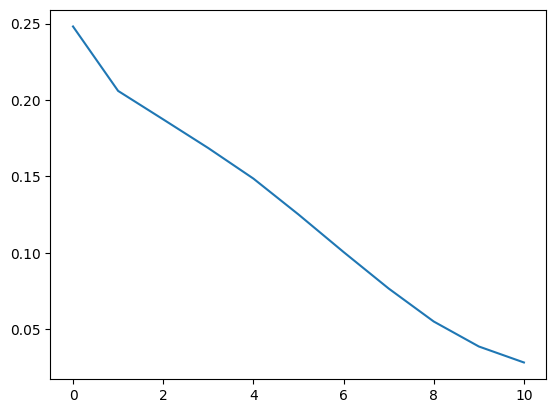

In [34]:
plt.plot(loss_history)

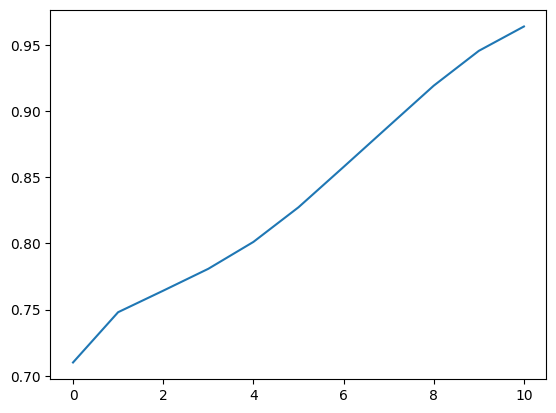

In [35]:
plt.plot(train_acc_history)

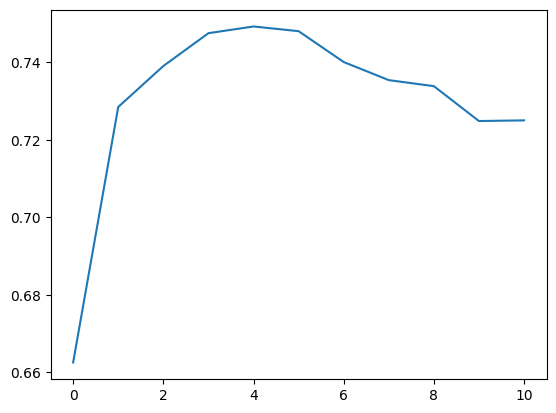

In [36]:
plt.plot(test_acc_history)

## 6. Generation with Trained Model

In [53]:
llm_model.processor.image_processor.std

0.5

In [37]:
_ = [m.eval() for m in train_models]

In [6]:
@torch.inference_mode()
def generate(image, question = 'describe the image'):
    msgs = [{'role': 'user', 'content': [image.convert('RGB'), question]}]

    answer = llm_model.chat(
        image=None,
        msgs=msgs,
        tokenizer=tokenizer,
        processor=processor,
        sampling=False,
    )

    return answer

### 6.1. Test Samples

In [44]:
test_samples = hf_dataset_sampled['test'].shuffle().select(range(6))[:]

In [60]:
gt_texts = [d['prompt'] for d in test_samples['json']]

In [61]:
test_samples.keys()

dict_keys(['jpg', 'json', '__key__', '__url__', 'prompt', 'pil_image'])

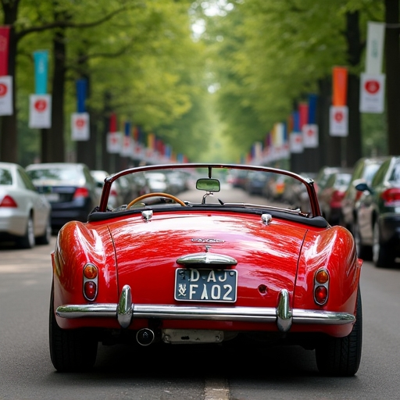

gen_text :  The image shows a vintage red convertible car with a black soft-top roof, parked on a street lined with trees. The car has a distinctive design with a long hood and a short rear deck, and it features a license plate that reads 'D-AJ & FA02'. The street is lined with various other cars, and there are flags and banners hanging from the trees. The scene gives the impression of a car show or a parade, with the vintage car as the focal point.
gt_text  :   A red convertible sports car is parked on a street lined with trees and flags. The car has a license plate that reads 'D-AJ 4242'. There are other cars parked in the background, and the scene appears to be in a park-like setting.


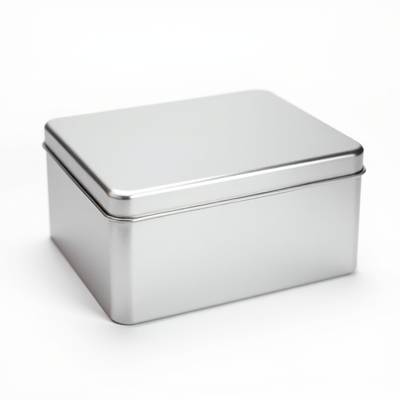

gen_text :  The image shows a silver metal box with a lid, placed on a white background. The box has a smooth surface and is rectangular in shape. The lid is closed, and the box appears to be empty. There are no other objects in the image.
gt_text  :   A silver metal box with a rectangular shape and a hinged lid is displayed against a white background. The box has a smooth surface and no visible markings or logos.


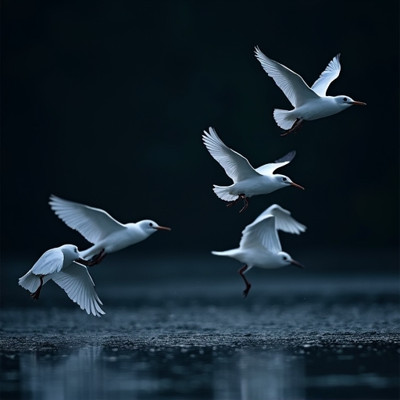

gen_text :  Four white birds with long beaks are flying over a dark surface with a reflective quality, possibly water. The birds are spread out, with one on the left, one in the center, and two on the right. The surface they are flying over has a pattern of lines and dots, and the background is dark, which contrasts with the birds' white feathers.
gt_text  :   A group of white birds is seen in flight at night, with their silhouettes illuminated by a light source from the left. The birds are flying over a wet surface, possibly a body of water, with a dark background that suggests it is nighttime. The birds are in various stages of flight, with some appearing closer to the ground and others higher up.


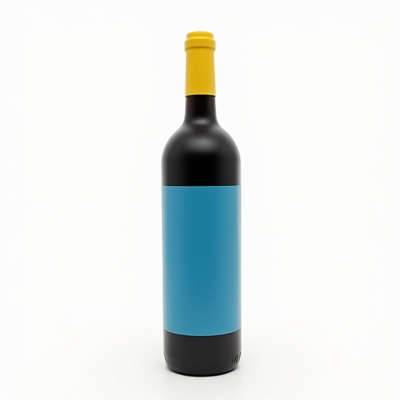

gen_text :  The first image is a close-up of a wine bottle with a blue label and a yellow cap. The label has a simple design with a blue background and a yellow border. The bottle is placed against a white background, and the focus is on the bottle and its label. There are no other objects or text in the image.
gt_text  :   A bottle of wine with a blue label and a yellow cap is isolated against a white background.


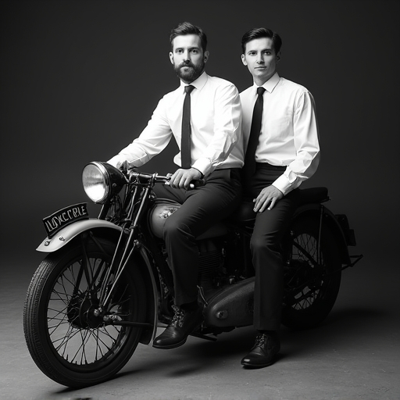

gen_text :  a man in a white shirt and tie is sitting on a motorcycle with another man in a white shirt and tie sitting on the back of the motorcycle
gt_text  :   A black and white photograph of two men sitting on a vintage motorcycle. The men are wearing white shirts and dark pants, and they are both wearing ties. The motorcycle has a large front wheel and a smaller rear wheel, and it is equipped with a sidecar. The license plate on the sidecar reads 'MOTORCYCLE'. The background is dark, and the image has a vintage feel.


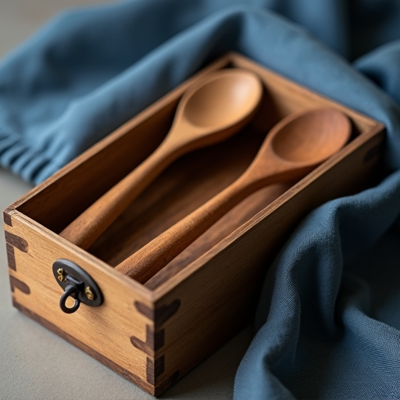

gen_text :  A wooden box with a blue cloth draped over it contains two wooden spoons. The box has a metal lock on the front and a black handle. The spoons are placed side by side, with the one on the left being slightly taller than the one on the right. The box is placed on a surface with a patterned design.
gt_text  :   A wooden box with two wooden spoons inside it, one on top of the other. The box is placed on a surface with a blue cloth partially visible in the background.


In [62]:
for img, gt_text in zip(test_samples['jpg'], gt_texts):
    gen_text = generate(img)
    display(img.resize((400, 400)))
    print('gen_text : ', gen_text)
    print('gt_text  :  ', gt_text)
    print('='*70)

### 6.2. Train Samples

In [56]:
train_samples = hf_dataset_sampled['train'].shuffle().select(range(6))[:]

In [63]:
gt_texts = [d['prompt'] for d in train_samples['json']]

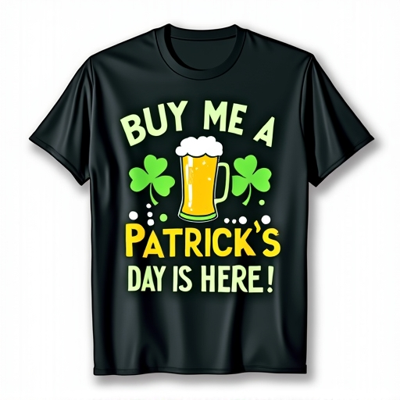

gen_text :  The image features a black t-shirt with a graphic design. The design includes the text 'BUY ME A PATRICK'S DAY IS HERE!' in a playful, stylized font. The text is accompanied by a green shamrock and a beer mug, both of which are common symbols associated with St. Patrick's Day. The t-shirt is set against a white background, and the image is framed with a black border.
gt_text  :   A black t-shirt with a graphic design that reads 'Buy me a beer St. Patrick's Day is here!' in green and yellow text. The design features a shamrock and a beer mug. The t-shirt is on a white background with a shadow effect, giving the impression of a real garment.


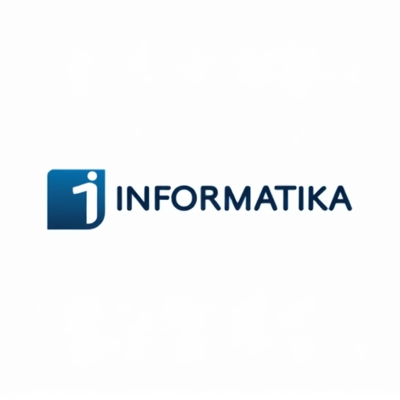

gen_text :  The image features a minimalist logo design for a company named 'INFORMATIKA'. The logo is composed of a blue square with a white space in the center, and the company name 'INFORMATIKA' is written in a simple, sans-serif font below the square. The background is a plain white color, which contrasts with the blue of the logo and the black of the text. The overall design is clean and modern, with a focus on simplicity and clarity.
gt_text  :   A white background with a blue and white logo that reads 'INFORMATIKA' in a stylized font. The logo features a blue square with a white border, and inside the square, there is a stylized letter 'I' with a blue outline and a white interior. The letter 'I' is positioned to the left of the word 'FORMATIKA', which is written in a cursive style with the letters 'F', 'O', 'R', 'M', 'A', 'T', 'I', 'K', and 'A' in a blue color.


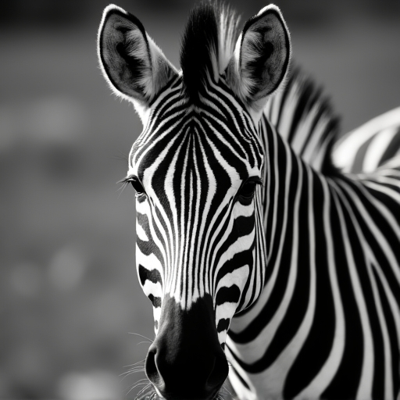

gen_text :  The image is a close-up of a zebra's face with a black and white color scheme. The zebra's face is centered in the frame, and the image is in focus, highlighting the detailed stripes and the animal's eyes. The background is blurred, emphasizing the zebra's face.
gt_text  :   A close-up image of a zebra's face with a black and white pattern. The zebra's face is centered in the frame, and the image is in focus. The background is a blurred version of the zebra's face, with the same black and white pattern.


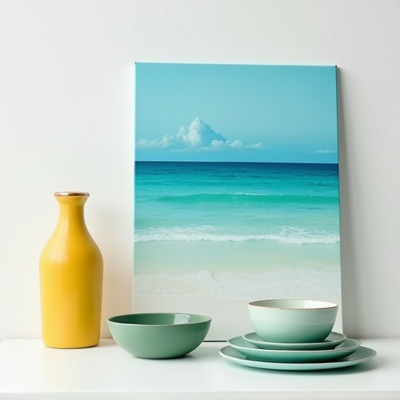

gen_text :  The image features a white wall with a beach scene painting. The painting depicts a clear blue sky with a few clouds, a calm ocean with gentle waves, and a sandy beach with a few footprints. There are three plates and a bowl placed on the wall, with a yellow vase to the left. The plates are arranged in a way that suggests they are part of a decorative display, with the bowl placed on top of the plates.
gt_text  :   A white table with a blue ocean scene on a canvas, a yellow bottle, a green plate, and a stack of green and white plates.


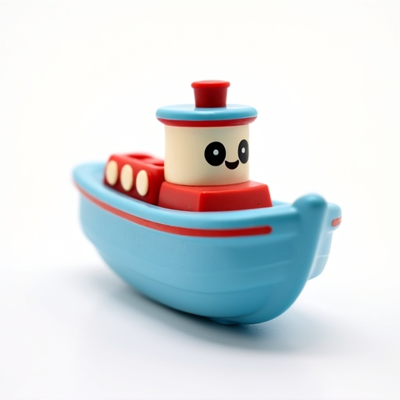

gen_text :  A colorful toy boat with a smiling face, featuring a blue body, red and white stripes, and a black and white face with a red mouth. The boat is floating on a white background.
gt_text  :   A small, colorful toy boat with a smiling face, featuring a blue body, red and white stripes, and a black and white face with a red mouth. The boat is floating on a white background.


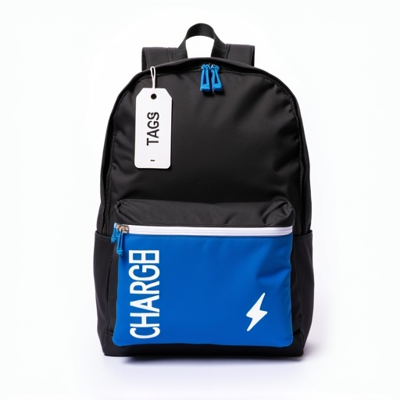

gen_text :  The image shows a black and blue backpack with a white tag that reads 'TAGS'. The backpack has a large 'CHARGE' logo on the front in white text, and there is a small white lightning bolt symbol to the right of the text. The backpack is placed against a white background.
gt_text  :   A black and blue backpack with a white tag reading 'TAG' is displayed against a white background. The backpack has a large 'CHARGER' text on the left side in white letters, and a smaller 'CHARGER' text on the right side in white letters. The backpack also features a lightning bolt logo in white on a blue background on the lower right side.


In [67]:
for img, gt_text in zip(train_samples['jpg'], gt_texts):
    gen_text = generate(img)
    display(img.resize((400, 400)))
    print('gen_text : ', gen_text)
    print('gt_text  :  ', gt_text)
    print('='*70)

In [68]:
del llm_model
torch.cuda.empty_cache()

### 6.3. With Initial Model

In [5]:
llm_model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
_ = llm_model.eval()

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

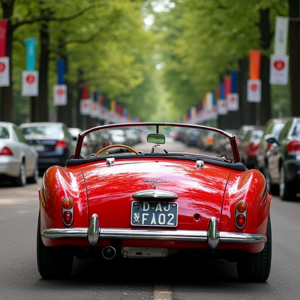

gen_text :  The image captures a vibrant scene on a tree-lined street. Dominating the center of the frame is a classic red convertible car, its shiny exterior reflecting the sunlight. The car's license plate reads "DAJ FA02", adding a touch of authenticity to the scene. The car is parked on the right side of the street, facing away from the camera, as if ready to drive off into the distance.

The street itself is lined with lush green trees, their leaves forming a natural canopy overhead. Adding to the festive atmosphere, colorful banners hang from the trees, fluttering gently in the breeze. These banners, along with the classic car, suggest that this could be a special event or celebration.

In the background, other cars can be seen parked along the street, their colors muted compared to the striking red of the convertible. Despite their presence, the red car remains the focal point of the image, drawing the viewer's eye with its bright color and classic design. The overall compositio

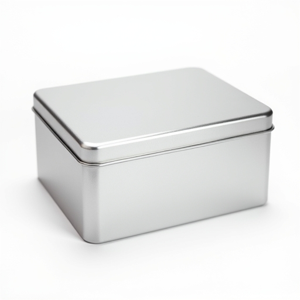

gen_text :  The image presents a single object, a rectangular tin box, resting on a white surface. The box is characterized by a smooth, metallic finish that reflects light, giving it a shiny appearance. The lid of the box is slightly ajar, revealing a hint of the contents within. The box is positioned centrally in the frame, with no other objects to distract from it. The simplicity of the scene focuses the viewer's attention solely on the tin box. There is no text or additional elements in the image. The relative position of the box to the surface and the absence of other objects suggest that the box is the main subject of this image. The image does not provide any information about the contents of the box or its purpose. The overall impression is one of minimalism and simplicity.
gt_text  :   A silver metal box with a rectangular shape and a hinged lid is displayed against a white background. The box has a smooth surface and no visible markings or logos.


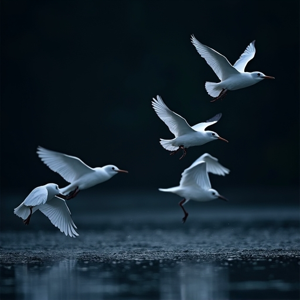

gen_text :  In the image, a quartet of white seagulls is captured in mid-flight, their wings spread wide against the backdrop of a dark, cloudy sky. The seagulls are arranged in a diagonal line, creating a sense of movement and direction. The first seagull is positioned on the left side of the image, while the last one is on the right, leading the formation. The seagulls are flying over a body of water, which is visible in the bottom right corner of the image. The water's surface is calm, providing a stark contrast to the dynamic flight of the seagulls. The overall composition of the image suggests a moment frozen in time, as the seagulls soar through the air.
gt_text  :   A group of white birds is seen in flight at night, with their silhouettes illuminated by a light source from the left. The birds are flying over a wet surface, possibly a body of water, with a dark background that suggests it is nighttime. The birds are in various stages of flight, with some appearing closer to the g

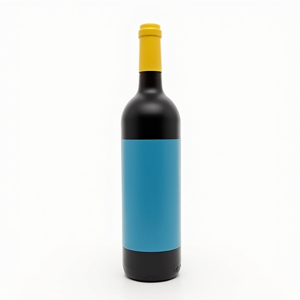

gen_text :  The image presents a single wine bottle, standing upright against a stark white background. The bottle is dark, possibly black, with a distinctive yellow cap that adds a pop of color to the otherwise monochromatic scene. The most striking feature of the bottle is its label, which is a vibrant shade of blue. The label is blank, devoid of any text or design, suggesting that it's ready for customization. The bottle's position in the center of the frame draws the viewer's attention directly to it, emphasizing its simplicity and elegance. The overall composition of the image is minimalist, with the wine bottle as the sole focus.
gt_text  :   A bottle of wine with a blue label and a yellow cap is isolated against a white background.


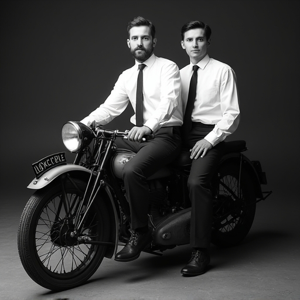

gen_text :  In the black and white photograph, two men are seated on a vintage motorcycle. The man on the left, distinguished by his beard, is dressed in a crisp white shirt paired with a black tie. His counterpart on the right, sporting a clean-shaven face, is similarly attired in a white shirt and black tie. The motorcycle they're perched on is a classic model, its round headlight and large front wheel hinting at its vintage charm. The backdrop is a simple gray, allowing the focus to remain on the two men and their motorcycle. The overall composition of the image suggests a moment frozen in time, capturing the essence of a bygone era.
gt_text  :   A black and white photograph of two men sitting on a vintage motorcycle. The men are wearing white shirts and dark pants, and they are both wearing ties. The motorcycle has a large front wheel and a smaller rear wheel, and it is equipped with a sidecar. The license plate on the sidecar reads 'MOTORCYCLE'. The background is dark, and the ima

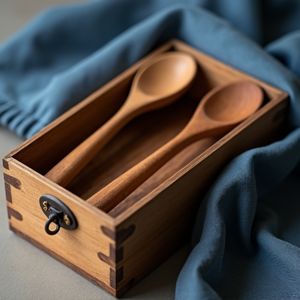

gen_text :  In the center of the image, there's a wooden box with a black handle on the right side. The box is resting on a blue cloth, which is slightly crumpled, adding a sense of casualness to the scene. Inside the box, there are two wooden spoons, their light brown color contrasting with the darker hue of the box. The spoons are arranged in such a way that they appear to be leaning against each other, creating a sense of balance and symmetry. The background is blurred, drawing focus to the box and its contents. The overall image gives a sense of simplicity and elegance.
gt_text  :   A wooden box with two wooden spoons inside it, one on top of the other. The box is placed on a surface with a blue cloth partially visible in the background.


In [10]:
for img, gt_text in zip(test_samples['jpg'], [d['prompt'] for d in test_samples['json']]):
    gen_text = generate(img)
    display(img.resize((300, 300)))
    print('gen_text : ', gen_text)
    print('gt_text  :  ', gt_text)
    print('='*70)